In [1]:
import torch
import os
import torchvision
import numpy as np
import albumentations
from torchvision.datasets import CelebA

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def center_by_face(image: torch.Tensor, landmarks: torch.Tensor):
    image, landmarks = np.transpose(image.numpy(), (1,2,0)), landmarks.numpy()
    # y_center = int(landmarks[36][0] + landmarks[45][0]) // 2
    # x_center = int(landmarks[:,1].mean().item())
    y, x = landmarks[:,0], landmarks[:,1]
    keypoints_landmarks = [x, y, 0, 1]
    # H, W, C = image.shape
    # W_max = min(x_center, W - x_center)
    # H_max = min(y_center, H - y_center)
    # radius = min(W_max, H_max)
    # y_max, y_min = min(H, y_center + H//2), max(0, y_center - H//2)
    # x_max, x_min = min(W, x_center + W//2), max(0, x_center - W//2)
    H, W, C = image.shape
    H09 = int(H * 0.9)
    rh = max(int(270 * H09 / W), 270)
    rw = max(int(270 * W / H09), 270)
    transforms = albumentations.Compose([
        albumentations.Crop(x_min=0, y_min=0, x_max=W, y_max=H09),
        albumentations.Resize(rh, rw),
        albumentations.RandomCrop(256, 256)
    ])
    data_dict = transforms(image=image, keypoints=[keypoints_landmarks])
    image_new = torch.tensor(np.transpose(data_dict['image'], (2,0,1)))
    kp_x, kp_y = data_dict['keypoints'][0][0], data_dict['keypoints'][0][1]
    keypoints_new = torch.cat([torch.tensor(kp_x)[..., None], torch.tensor(kp_y)[..., None]], dim=1)
    return image_new, keypoints_new

def kp_normalize(H, W, kp):
    kp = kp.clone()
    kp[..., 0] = kp[..., 0] / (W-1)
    kp[..., 1] = kp[..., 1] / (H-1)
    return kp

In [3]:
class OurCeleba(CelebA):
    def _check_integrity(self):
        return True
    
    def __getitem__(self, index):
        data, kp = super().__getitem__(index)
        data = torch.from_numpy(np.asarray(data)).permute(2,0,1)
        print(data.shape)
        kp = torch.tensor([(kp[i].item(), kp[i+1].item()) for i in range(0,len(kp),2)])
        
        data, kp = center_by_face(data, kp[:, [1, 0]]) # kp[:, [0, 1]])
        C, H, W = data.shape
        meta = {'keypts': kp, 'keypts_normalized': kp_normalize(W, H, kp), 'index': index}

        return {"data": data, "meta": meta}


In [4]:
celeba_dataset = OurCeleba("/raid/data/", target_type="landmarks", download=False, split='train')

In [5]:
slovarik = celeba_dataset[1]

torch.Size([3, 218, 178])


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [6]:
print(slovarik['data'].shape)
print(slovarik['meta']['keypts_normalized'].shape)
print(slovarik['meta']['keypts'])
print(slovarik['meta']['keypts'][:,1])

torch.Size([3, 256, 256])
torch.Size([5, 2])
tensor([[ 99.1461, 154.2296],
        [162.8539, 151.1990],
        [143.1348, 193.6276],
        [ 96.1124, 213.3265],
        [161.3371, 210.2959]], dtype=torch.float64)
tensor([154.2296, 151.1990, 193.6276, 213.3265, 210.2959], dtype=torch.float64)


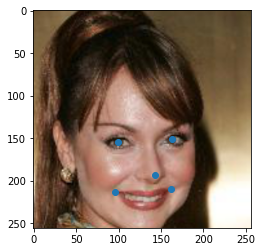

In [11]:
# plt.scatter(kps1[0], kps1[1])
plt.scatter(slovarik['meta']['keypts_normalized'][:,0] *255, slovarik['meta']['keypts_normalized'][:,1]*255)
plt.imshow(slovarik['data'].permute(1,2,0))

In [32]:
a = [1,2,3,4,5,6]
torch.tensor([(a[i],a[i+1]) for i in range(0,len(a),2)])

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [35]:
torch.tensor([(celeba_dataset[0][1][i].item(), celeba_dataset[0][1][i+1].item()) for i in range(0,len(celeba_dataset[0][1]),2)]).shape

torch.Size([5, 2])

In [6]:
len(celeba_dataset)

19000

In [16]:
celeba_dataset[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x7FE1503664A8>,
 tensor([ 67, 110, 108, 113,  78, 133,  71, 149, 109, 153]))

In [ ]:
('newfile.txt', 'w', encoding='utf-8') as g: